### **II. Packages**

First, let's install required packages !

In [1]:
!pip install opencv-python
!pip install mediapipe
!pip install tqdm
!pip install h5py


[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: C:\Users\o\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: C:\Users\o\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: C:\Users\o\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: C:\Users\o\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


--

Now that the packages are installed, let's import and use them :)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import cv2

import mediapipe as mp
from mediapipe.framework.formats import landmark_pb2
from mediapipe import solutions

In [1]:
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import Input, Dense, LSTM, Concatenate, GlobalAveragePooling2D, TimeDistributed, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import h5py
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler

## **III. Dataset**

#### **III.1. Load Training Data**
Now, let's load our data using pyH5 package. The training data contains images, landmarks coordinates and labels.

In [5]:

## 1. IMAGES
h5f = h5py.File('C:\\Users\\o\\Downloads\\dynamic-facial-expressions-recognition\\data_train_images.h5','r')
train_images = h5f['data_train_images'][:]
h5f.close()

## 2. LANDMARKS
h5f = h5py.File('C:\\Users\\o\\Downloads\\dynamic-facial-expressions-recognition\\data_train_landmarks.h5','r')
train_landmarks = h5f['data_train_landmarks'][:]
h5f.close()

## 3. LABELS
h5f = h5py.File('C:\\Users\\o\\Downloads\\dynamic-facial-expressions-recognition\\data_train_labels.h5','r')
train_labels = h5f['data_train_labels'][:]
h5f.close()

print("> Images")
print('Number of training images     :', train_images.shape[0])
print('Number of frames per sequence :', train_images.shape[1])
print('Image shape                   :', train_images[0][0].shape)

print("\n> Landmarks")
print('Number of landmarks in a face      :', train_landmarks.shape[2])
print('Number of coordinates per landmark :', train_landmarks.shape[-1])


print("\n> Labels")
print('Number of training labels:', train_labels.shape[0])

## Create an expression map to map labels (integer values) to the corresponding expression
expressions = ['Happy','Fear','Surprise','Anger','Disgust','Sad']
expression_mapping = dict(zip(range(len(expressions)), expressions))
print('\n> Expressions map:')
print(expression_mapping)

> Images
Number of training images     : 486
Number of frames per sequence : 10
Image shape                   : (200, 200)

> Landmarks
Number of landmarks in a face      : 478
Number of coordinates per landmark : 3

> Labels
Number of training labels: 486

> Expressions map:
{0: 'Happy', 1: 'Fear', 2: 'Surprise', 3: 'Anger', 4: 'Disgust', 5: 'Sad'}


Text(0.5, 1.0, 'Happy')

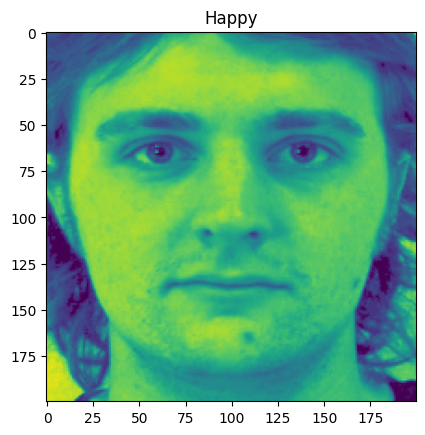

In [6]:
#afficher une image random
random_image = np.random.randint(0, train_images.shape[0])
plt.imshow(train_images[random_image][0])
plt.title(expression_mapping[train_labels[random_image]])

Text(0.5, 1.0, 'Anger')

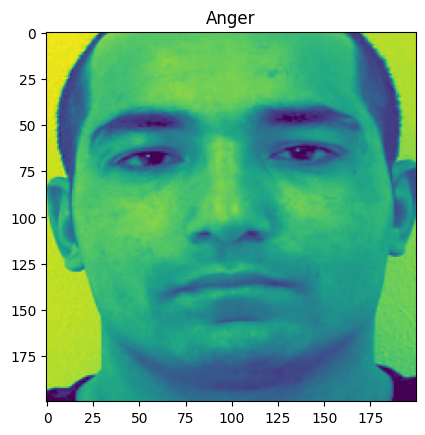

In [7]:
# dsiplay the landmarks of a random image
random_image = np.random.randint(0, train_images.shape[0])
plt.imshow(train_images[random_image][0])
plt.title(expression_mapping[train_labels[random_image]])


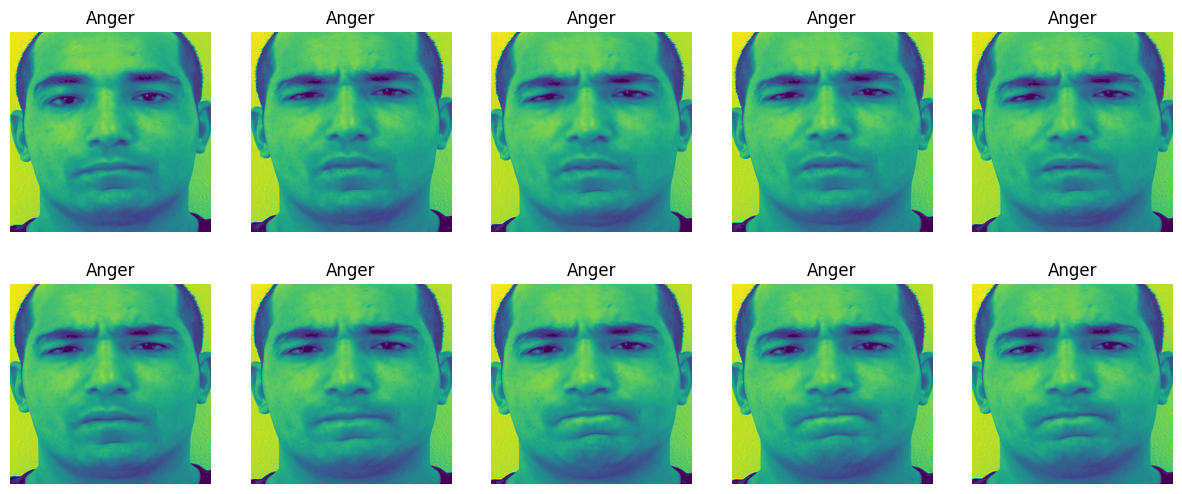

In [8]:
#afficher les 10 frames pour chaque image random
fig, ax = plt.subplots(2,5, figsize=(15,6))
for i in range(2):
    for j in range(5):
        ax[i,j].imshow(train_images[random_image][i*5+j])
        ax[i,j].set_title(expression_mapping[train_labels[random_image]])
        ax[i,j].axis('off')
        

#### **III.1. Load Test Data**
For the test data, we only have access to images and landmarks coordinates ! **LABELS ARE NOT AVAILABLE !**
> **Note:** You are supposed to train a model to predict the labels for the testing samples.

In [9]:
## Loading testing data tables from H5py files
## 1. IMAGES
h5f = h5py.File('C:\\Users\\o\\Downloads\\dynamic-facial-expressions-recognition\\data_test_images.h5','r')
test_images = h5f['data_test_images'][:]
h5f.close()

## 2. LANDMARKS
h5f = h5py.File('C:\\Users\\o\\Downloads\\dynamic-facial-expressions-recognition\\data_test_landmarks.h5','r')
test_landmarks = h5f['data_test_landmarks'][:]
h5f.close()

## display the size of the different data tables
print("> Images")
print('Number of testing images      :', test_images.shape[0])
print('Number of frames per sequence :', test_images.shape[1])
print('Image shape                   :', test_images[0][0].shape)

print("\n> Landmarks")
print('Number of landmarks in a face      :', test_landmarks.shape[2])
print('Number of coordinates per landmark :', test_landmarks.shape[-1])

> Images
Number of testing images      : 206
Number of frames per sequence : 10
Image shape                   : (200, 200)

> Landmarks
Number of landmarks in a face      : 478
Number of coordinates per landmark : 3


#### **III.2. Visualize Data**

In [10]:
def draw_landmarks_on_face(image, landmarks, draw_tesselation=True, draw_contours=True, draw_irises=True):
    """
    image: np.ndarray of shape (W, H) or (W, H, 3)
    landmarks: np.ndarray of shape (L=478, d=3)
    """

    ## image should be BGR
    if len(image.shape) == 2:
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    annotated_image = np.copy(image)

    ## Put the landmarks in a normalized list
    face_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
    face_landmarks_proto.landmark.extend([
              landmark_pb2.NormalizedLandmark(x=x, y=y, z=z) for (x, y, z) in landmarks
            ])

    if draw_tesselation:
        ## FACE MESH TESSELATION
        solutions.drawing_utils.draw_landmarks(
            image=annotated_image,
            landmark_list=face_landmarks_proto,
            connections=mp.solutions.face_mesh.FACEMESH_TESSELATION,
            landmark_drawing_spec=None,
            connection_drawing_spec=mp.solutions.drawing_styles
            .get_default_face_mesh_tesselation_style())

    if draw_contours:
        ## FACE MESH CONTOURS
        solutions.drawing_utils.draw_landmarks(
            image=annotated_image,
            landmark_list=face_landmarks_proto,
            connections=mp.solutions.face_mesh.FACEMESH_CONTOURS,
            landmark_drawing_spec=None,
            connection_drawing_spec=mp.solutions.drawing_styles
            .get_default_face_mesh_contours_style())

    if draw_irises:
        ## FAC MESH IRISES
        solutions.drawing_utils.draw_landmarks(
            image=annotated_image,
            landmark_list=face_landmarks_proto,
            connections=mp.solutions.face_mesh.FACEMESH_IRISES,
              landmark_drawing_spec=None,
              connection_drawing_spec=mp.solutions.drawing_styles
              .get_default_face_mesh_iris_connections_style())

    return annotated_image


def draw_image_sequence(sequence, dispaly_frames_title=False, sup_title=None):

    """
    sequence: list/numpy array of shape (N, W, H) or (N, W, H, 3)
    """

    N = len(sequence)

    plt.figure(figsize=(22, 2))
    for i, img in enumerate(sequence, start=1):
        plt.subplot(1, N, i)
        plt.imshow(img, cmap='gray')
        plt.axis('off')
        if dispaly_frames_title:
            plt.title(f'frame {i}')
    if sup_title is not None:
        plt.suptitle(sup_title)
    plt.show()

def draw_landmarks_on_face_sequence(landmarks_sequence, image_sequence=None, draw_tesselation=True, draw_contours=True, draw_irises=True, title=None):
    """
    landmarks_sequence: list/numpy array of shape (N, L=478, d=3)
    image_sequence[optional]: list/numpy array of shape (N, W, H) or (N, W, H, 3)
    """

    N = landmarks_sequence.shape[0]

    if image_sequence is not None:
        ## landmarks_sequence & image_sequence should have the same number of samples !
        assert len(image_sequence) == len(landmarks_sequence)
    else:
        image_sequence = np.zeros((N, 200, 200, 3)).astype(np.uint8)

    annotated_images = []
    for i, (img, landamrks) in enumerate(zip(image_sequence, landmarks_sequence), start=1):
        annotated_image = draw_landmarks_on_face(img,
                                                 landamrks,
                                                 draw_tesselation=draw_tesselation,
                                                 draw_contours=draw_contours,
                                                 draw_irises=draw_irises)
        annotated_images.append(annotated_image)

    draw_image_sequence(annotated_images, sup_title=title)

Sequence label: Fear


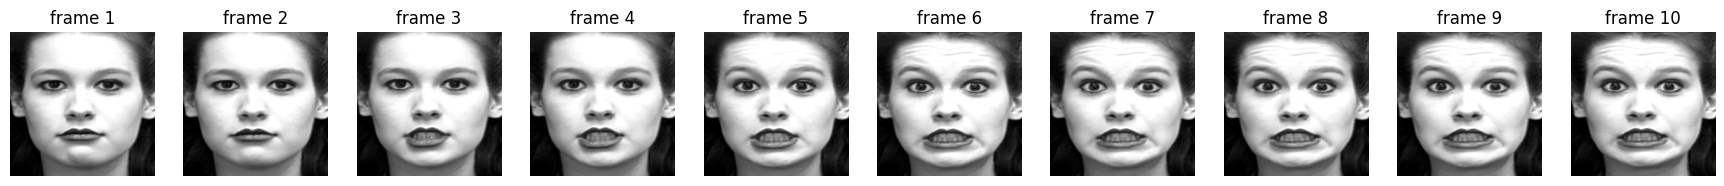

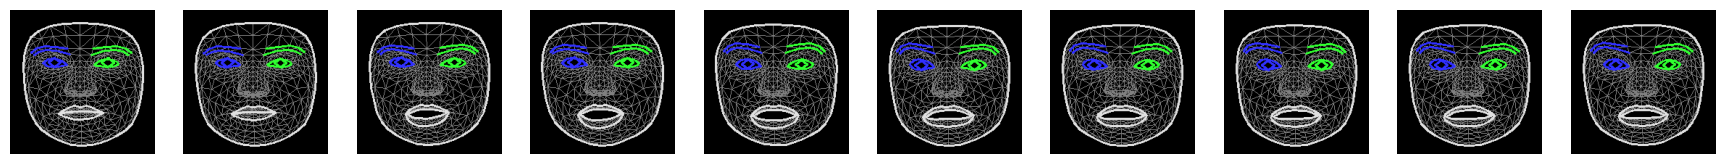

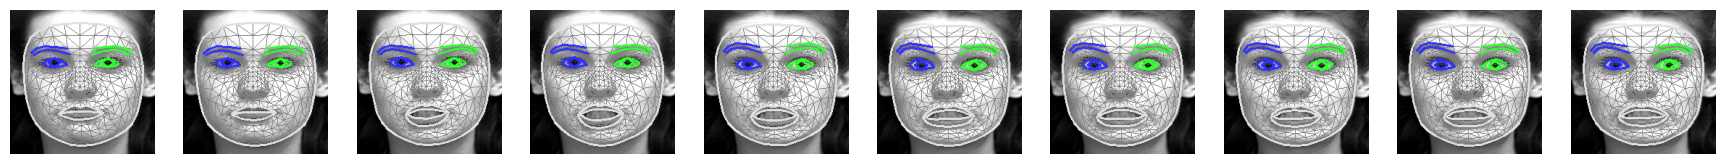

In [11]:
## display a random sequence
idx = np.random.randint(len(train_landmarks))
img_sequence = train_images[idx]
landmarks_sequence = train_landmarks[idx]
print(f'Sequence label: {expression_mapping[train_labels[idx]]}')

## display original sequence
draw_image_sequence(img_sequence, dispaly_frames_title=True)

## draw original landmarks
draw_landmarks_on_face_sequence(landmarks_sequence)

## draw images and landmarks
draw_landmarks_on_face_sequence(landmarks_sequence, img_sequence)

You can also use the following function to extract differents meshes from the face landmarks including: TESSELATION (in gray), CONTOURS (in white, blue and green) and IRISES in (green and blue).

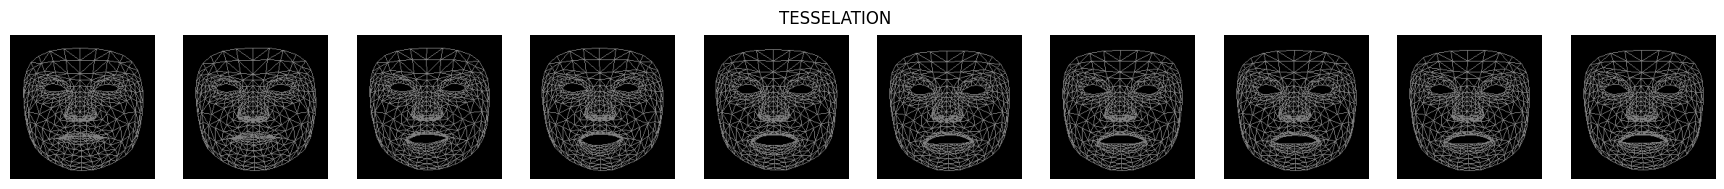

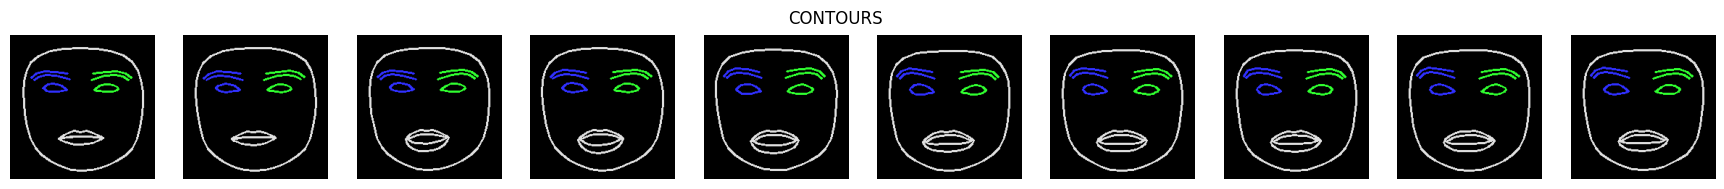

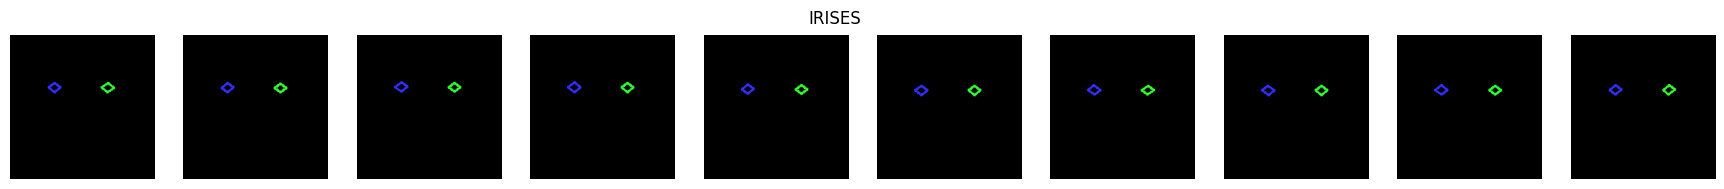

In [12]:
## draw TESSELATION ONLY
draw_landmarks_on_face_sequence(landmarks_sequence, draw_tesselation=True, draw_contours=False, draw_irises=False, title='TESSELATION')
## draw CONTOURS ONLY
draw_landmarks_on_face_sequence(landmarks_sequence, draw_tesselation=False, draw_contours=True, draw_irises=False, title='CONTOURS')
## draw IRISES ONLY
draw_landmarks_on_face_sequence(landmarks_sequence, draw_tesselation=False, draw_contours=False, draw_irises=True, title='IRISES')

In [13]:
def extract_tesselation_landmarks(landmarks):
    """Returns the TESSELATION LANDMARKS"""
    ## get tesselation landmarks indices
    TESSELATION_INDICES = list(mp.solutions.face_mesh.FACEMESH_TESSELATION)
    TESSELATION_INDICES = np.unique(TESSELATION_INDICES)
    ## extract landmarks
    TESSELATION_landmarks = landmarks[TESSELATION_INDICES]
    return TESSELATION_landmarks

def extract_contours_landmarks(landmarks):
    """Returns the CONTOURS LANDMARKS"""
    ## get contours landmarks indices
    CONTOURS_INDICES = list(mp.solutions.face_mesh.FACEMESH_CONTOURS)
    CONTOURS_INDICES = np.unique(CONTOURS_INDICES)
    ## extract landmarks
    contours_landmarks = landmarks[CONTOURS_INDICES]
    return contours_landmarks

def extract_irises_landmarks(landmarks):
    """Returns the IRISES LANDMARKS"""
    ## get irises landmarks indices
    IRISES_INDICES = list(mp.solutions.face_mesh.FACEMESH_IRISES)
    IRISES_INDICES = np.unique(IRISES_INDICES)
    ## extract landmarks
    irises_landmarks = landmarks[IRISES_INDICES]
    return irises_landmarks

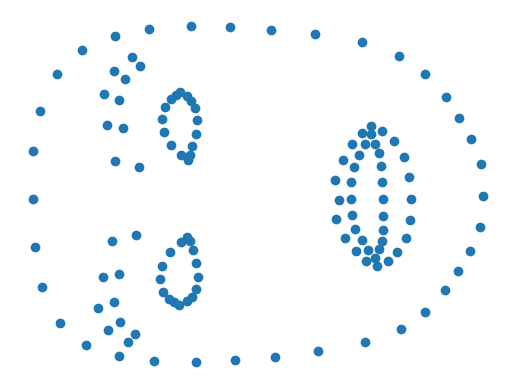

In [15]:
## an example: extracting the contours landmarks
contours_landmarks = extract_contours_landmarks(landmarks_sequence[-1])
plt.scatter(contours_landmarks[:, 1], contours_landmarks[:, 0])
plt.axis('off')
plt.show()

## **YOUR TURN !**
#### **Now it's up to you to preprocess the data, build, train and evaluate your models ! BE CREATIVE !**

In [14]:
print("Train images shape:", train_images.shape)

print("Train landmarks shape:", train_landmarks.shape)

print("Train labels shape:", train_labels.shape)


Train images shape: (486, 10, 200, 200)
Train landmarks shape: (486, 10, 478, 3)
Train labels shape: (486,)


#### Générateur d'Images Augmentées

Le code suivant initialise un `ImageDataGenerator` conçu pour augmenter des images via différentes transformations. Cette augmentation d'image est essentielle pour éviter l'overfitting et améliorer la généralisation du modèle en introduisant une diversité dans les données d'entraînement sans nécessiter plus d'images originales.

In [4]:
# Création d'une instance de ImageDataGenerator avec des paramètres spécifiques pour l'augmentation d'images
image_data_gen = ImageDataGenerator(
    rotation_range=10,  # Permet des rotations d'images jusqu'à 10 degrés
    width_shift_range=0.1,  # Permet des translations horizontales jusqu'à 10% de la largeur de l'image
    zoom_range=0.1,  # Permet un zoom avant et arrière jusqu'à 10%
    horizontal_flip=True  # Permet de retourner les images horizontalement
)

# Définition d'une fonction pour augmenter un batch d'images
def augment_images(images):
    # Création d'un tableau pour stocker les images augmentées avec la même forme que le tableau d'entrée
    augmented_images = np.zeros_like(images)
    
    # Itération sur chaque image du tableau d'entrée
    for i in range(images.shape[0]):  # Itération sur la première dimension (les différentes images)
        for j in range(images.shape[1]):  # Itération sur la deuxième dimension (si images est un tableau 4D)
            # Application de la transformation aléatoire sur chaque image et sauvegarde dans le tableau des images augmentées
            augmented_images[i, j] = image_data_gen.random_transform(images[i, j])
    
    # Retour du tableau des images augmentées
    return augmented_images

# Construction et Prétraitement pour le Modèle de Classification

## Fonction `build_model`

La fonction `build_model` est conçue pour construire un modèle de deep learning qui intègre des caractéristiques visuelles et des landmarks (points de repère) pour effectuer une classification. Ce modèle utilise l'architecture MobileNet pré-entraînée sur ImageNet comme base pour le traitement des images, et combine ses caractéristiques avec celles extraites de séquences de landmarks à travers des couches LSTM.

### Paramètres

- `input_shape_img`: La forme des données d'entrée d'image, incluant le nombre de séquences, la hauteur, la largeur et les canaux.
- `input_shape_landmark`: La forme des données d'entrée des landmarks, incluant le nombre de séquences et les caractéristiques par séquence.
- `num_classes`: Le nombre de classes pour la classification.
- `fine_tune`: Un booléen qui détermine si les dernières couches de MobileNet doivent être entraînées (affinées) ou non.

In [5]:
# Function to build a model that combines image and landmark features for classification.
def build_model(input_shape_img, input_shape_landmark, num_classes, fine_tune=False):
    # Load MobileNet as the base model, without the top layer, pre-trained on ImageNet. 
    # The input shape is specified based on the provided image shape.
    cnn_base = MobileNet(weights='imagenet', include_top=False, input_shape=(input_shape_img[2], input_shape_img[3], 3))
    
    # Fine-tune the model if requested:
    if fine_tune:
        # Unfreeze the last 10 layers for training to allow for feature adaptation.
        for layer in cnn_base.layers[-10:]:
            layer.trainable = True
    else:
        # Otherwise, keep the base CNN model frozen to retain pre-trained features.
        cnn_base.trainable = False

    # Define the input for images with the given shape, excluding the batch size dimension.
    img_input = Input(shape=input_shape_img[1:], name='image_input')
    # Apply the base CNN across each time step in the sequence using TimeDistributed.
    time_distributed_cnn = TimeDistributed(cnn_base)(img_input)
    # Global average pooling to reduce the dimensions and extract essential features.
    pooled_features = TimeDistributed(GlobalAveragePooling2D())(time_distributed_cnn)
    # LSTM layer to process the sequential data from the pooled features.
    image_features = LSTM(64)(pooled_features) 

    # Define the input for landmarks with the given shape, excluding the batch size dimension.
    landmark_input = Input(shape=input_shape_landmark[1:], name='landmark_input')
    # LSTM layer to process the sequential landmark data.
    landmark_features = LSTM(64)(landmark_input) 

    # Merge the features from images and landmarks.
    merged_features = Concatenate()([image_features, landmark_features])
    # A dense fusion layer to combine features with regularization to prevent overfitting.
    fusion_layer = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(merged_features)
    # Dropout layer to reduce overfitting by randomly dropping units during training.
    fusion_layer = Dropout(0.5)(fusion_layer)  
    # Output layer with softmax activation for classification into 'num_classes' categories.
    output = Dense(num_classes, activation='softmax')(fusion_layer)

    # Define the model with inputs for images and landmarks, and the final output.
    model = Model(inputs=[img_input, landmark_input], outputs=output)
    # Compile the model with Adam optimizer, categorical crossentropy as the loss function,
    # and track accuracy as a metric.
    model.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

    return model

# Data preprocessing steps:

# Adding a channel dimension to the train images to fit the model's input requirements.
train_images = np.expand_dims(train_images, -1)  
# Duplicate the single-channel grayscale images across 3 channels to mimic RGB input.
train_images = np.tile(train_images, (1, 1, 1, 1, 3))  
# Reshape the landmark data to fit the LSTM input requirements.
train_landmarks = train_landmarks.reshape(train_landmarks.shape[0], train_landmarks.shape[1], -1)  

# Normalize image pixel values to a range of 0 to 1.
train_images = train_images / 255.0

# Encode the categorical labels to one-hot vectors.
one_hot_encoder = OneHotEncoder(sparse=False)
train_labels_encoded = one_hot_encoder.fit_transform(train_labels.reshape(-1, 1))

# Scale landmark features to a range between 0 and 1 for model input.
scaler = MinMaxScaler()
train_landmarks_scaled = scaler.fit_transform(train_landmarks.reshape(train_landmarks.shape[0], -1))
# Reshape the scaled landmarks back to the original shape for the model input.
train_landmarks_scaled = train_landmarks_scaled.reshape(train_landmarks.shape)


C:\Users\Great X\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [6]:

train_images, val_images, train_landmarks_scaled, val_landmarks_scaled, train_labels_encoded, val_labels_encoded = train_test_split(
    train_images, train_landmarks_scaled, train_labels_encoded, test_size=0.2, random_state=42)

In [7]:

input_shape_img = train_images.shape  # Shape of the input images
input_shape_landmark = train_landmarks_scaled.shape  # Shape of the input landmarks
num_classes = train_labels_encoded.shape[1]  # Number of classes

train_images_augmented = augment_images(train_images)


model = build_model(input_shape_img, input_shape_landmark, num_classes, fine_tune=True)

model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image_input (InputLayer)    [(None, 10, 200, 200, 3)]    0         []                            
                                                                                                  
 time_distributed (TimeDist  (None, 10, 6, 6, 1024)       3228864   ['image_input[0][0]']         
 ributed)                                                                                         
                                                                                                  
 time_distributed_1 (TimeDi  (None, 10, 1024)             0         ['time_distributed[0][0]']    
 stributed)                                                                                       
                                                                                              

In [8]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6, verbose=1)


callbacks = [early_stopping, reduce_lr]


In [14]:

history = model.fit([train_images, train_landmarks_scaled], train_labels_encoded,
                    validation_data=([val_images, val_landmarks_scaled], val_labels_encoded),
                    epochs=30, batch_size=32, callbacks=callbacks)




val_loss, val_accuracy = model.evaluate([val_images, val_landmarks_scaled], val_labels_encoded)


print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

Epoch 1/30
13/13 [==============================] - 277s 20s/step - loss: 0.8072 - accuracy: 0.9897 - val_loss: 1.2237 - val_accuracy: 0.7959 - lr: 1.0000e-06
Epoch 2/30
13/13 [==============================] - 272s 21s/step - loss: 0.7913 - accuracy: 0.9974 - val_loss: 1.2240 - val_accuracy: 0.8061 - lr: 1.0000e-06
Epoch 3/30
13/13 [==============================] - 290s 22s/step - loss: 0.8152 - accuracy: 0.9948 - val_loss: 1.2336 - val_accuracy: 0.8061 - lr: 1.0000e-06
Epoch 4/30
13/13 [==============================] - 282s 22s/step - loss: 0.7987 - accuracy: 0.9974 - val_loss: 1.2392 - val_accuracy: 0.8163 - lr: 1.0000e-06
Epoch 5/30
13/13 [==============================] - 274s 21s/step - loss: 0.8004 - accuracy: 0.9948 - val_loss: 1.2451 - val_accuracy: 0.8163 - lr: 1.0000e-06
Epoch 6/30
13/13 [==============================] - 299s 23s/step - loss: 0.8030 - accuracy: 0.9948 - val_loss: 1.2457 - val_accuracy: 0.8265 - lr: 1.0000e-06
Epoch 7/30
13/13 [============================

In [10]:
## 1. IMAGES
h5f = h5py.File('data_test_images.h5','r')
test_images = h5f['data_test_images'][:]
h5f.close()

## 2. LANDMARKS
h5f = h5py.File('data_test_landmarks.h5','r')
test_landmarks = h5f['data_test_landmarks'][:]
h5f.close()

'''The IMAGE data - stored in h5 files (`.h5`) are represented in the form of an array of shape (N, T, H, W) where:
N: is the number of sequences in the dataset.
T: is the number of frames per sequence.
H: is the width of the images.
W: is the height of the images.
Consequently, the training set (`data_train_images.h5`) is of shape (486, 10, 200, 200), and the testing set is of shape (206, 10, 200, 200).
Similarly, the LANDMARKS - data stored in h5 files (`.h5`) are represented in the form of an array of shape (N, T, L, D), where:
N: is the number of sequences in the dataset.
T: is the number of frames per sequence.
L: is the number of landmarks extracted from the face.
D: is the number of coordinates in each landmark (in our case 3d coordinates: x, y and z).
Consequently, the trainig set (`data_train_landmarks.h5`) is of shape (486, 10, 478, 3), and the test dataset (`data_test_landmarks.h5`) is of shape (206, 10, 478, 3). Here 3 corresponds to the 3d coordinates x, y, and z.'''

In [11]:

test_images = np.expand_dims(test_images, -1)  # Add a channel dimension if needed
test_images = np.tile(test_images, (1, 1, 1, 1, 3))  # Convert to 3 channels if needed
test_images = test_images / 255.0  # Normalize image data


test_landmarks = test_landmarks.reshape(test_landmarks.shape[0], test_landmarks.shape[1], -1)  # Reshape landmarks if needed
test_landmarks_scaled = scaler.transform(test_landmarks.reshape(test_landmarks.shape[0], -1))  # Scale landmark data
test_landmarks_scaled = test_landmarks_scaled.reshape(test_landmarks.shape)  # Reshape back to original



In [12]:

predictions = model.predict([test_images, test_landmarks_scaled])

predicted_labels = np.argmax(predictions, axis=1)

7/7 [==============================] - 20s 3s/step


In [13]:
predicted_labels
# 0.57 accuracy

array([3, 3, 4, 1, 1, 1, 0, 0, 5, 1, 2, 2, 3, 1, 3, 3, 3, 0, 0, 1, 1, 1,
       1, 1, 0, 1, 4, 2, 4, 3, 3, 1, 2, 2, 1, 4, 3, 0, 0, 3, 1, 1, 3, 3,
       2, 2, 0, 0, 4, 1, 0, 2, 2, 3, 4, 3, 3, 0, 0, 3, 3, 2, 3, 3, 0, 0,
       0, 0, 1, 4, 4, 4, 3, 2, 0, 0, 1, 0, 0, 3, 4, 0, 4, 5, 2, 2, 3, 3,
       2, 0, 3, 3, 2, 3, 1, 1, 0, 5, 2, 4, 1, 4, 1, 1, 4, 4, 3, 4, 1, 3,
       2, 0, 0, 1, 0, 2, 1, 4, 4, 4, 4, 4, 0, 4, 4, 4, 4, 2, 4, 1, 4, 3,
       3, 2, 4, 3, 3, 3, 3, 3, 3, 3, 0, 0, 3, 3, 3, 4, 2, 3, 3, 4, 4, 3,
       0, 0, 5, 5, 3, 3, 0, 0, 4, 0, 0, 3, 2, 0, 3, 3, 3, 4, 4, 1, 5, 0,
       0, 0, 3, 3, 3, 2, 2, 2, 2, 3, 3, 3, 2, 3, 0, 0, 0, 3, 3, 4, 2, 2,
       0, 0, 0, 0, 1, 4, 0, 0], dtype=int64)